### Starbucks Capstone Challenge
# Model Training

This notebook aims to train the models proposed to classify offers as appropriate or not.

## Define functions to train the classifiers

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN, RecurrentNN

### Load the datasets

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


### Define validation and training loops

In [3]:
def validate(model, dataloader=valid_dataloader, verbose=False):
    with torch.no_grad():
        model.eval()
        POS, NEG = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        valid_loss = 0
        for features, targets in dataloader:
            targets = targets.view(-1)
            positive = targets == 1
            negative = ~positive

            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            valid_loss += criterion(prediction, targets)

            prediction = torch.sigmoid(prediction)
            prediction = prediction.round()

            ## Compare prediction with target POSITIVE
            POS += positive.sum()
            # Target TRUE, Prediction TRUE --> True Positive
            TP += targets[positive].eq(prediction[positive]).sum()

            ## Compare prediction with target NEGATIVE
            NEG += negative.sum()
            # Target FALSE, Prediction FALSE --> True Negative
            TN += targets[negative].eq(prediction[negative]).sum()

        FN += POS - TP # Target TRUE, Prediction FALSE --> False Negative
        FP += NEG - TN # Target FALSE, Prediction TRUE --> False Positive

        # normalize the loss
        valid_loss /= len(dataloader)

        if verbose:
            print(f'\tValidation ... loss: {valid_loss:7.4f}')
            print(f'\t\tTP: {TP:4d}\tFP: {FP:4d}\tOP: {TP+FP:4d}')
            print(f'\t\tFN: {FN:4d}\tTN: {TN:4d}\tON: {TN+FN:4d}')
            print(f'\t\tCP: {POS:4d}\tCN: {NEG:4d}')
            print('\tAccuracy: {:5.2f}%\tPrecision: {:5.2f}\tRecall: {:5.2f}'
                  .format((TP+TN)/float(POS+NEG)*100,
                          TP/float(TP+FP), TP/float(TP+FN)))

        model.train()
        return valid_loss

In [4]:
def train(model, dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []

    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,1)
            targets = targets.view(-1,1).to(dtype=torch.float)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        lr_scheduler.step(train_loss[-1])

        if epoch % 10 == 0:
            print('Epoch {:4d}\ttrain loss: {:7.4f}\t' \
                  .format(epoch, train_loss[-1]))
            loss = validate(model, verbose=True)
            valid_loss.append(loss)
        else:
            loss = validate(model, verbose=False)
            valid_loss.append(loss)
            print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalid loss: {:7.4f}' \
                  .format(epoch, train_loss[-1], valid_loss[-1]))

    return train_loss, valid_loss

## Linear Classifier
This phase trains a feed-forward neural network to classify offer sending as appropriate or not.  
Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

In [5]:
linear_classifier = LinearNN(input_size=16, output_size=1,
                             hidden_layers=[128,128,128])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=100, verbose=True)

In [6]:
linear_loss = train(linear_classifier, epochs=100)

Epoch    1	train loss:  0.6536	valid loss:  0.6165
Epoch    2	train loss:  0.6143	valid loss:  0.6051
Epoch    3	train loss:  0.6072	valid loss:  0.6001
Epoch    4	train loss:  0.6034	valid loss:  0.5981
Epoch    5	train loss:  0.6013	valid loss:  0.5986
Epoch    6	train loss:  0.5995	valid loss:  0.5961
Epoch    7	train loss:  0.5982	valid loss:  0.5938
Epoch    8	train loss:  0.5971	valid loss:  0.5943
Epoch    9	train loss:  0.5961	valid loss:  0.5932
Epoch   10	train loss:  0.5957	
	Validation ... loss:  0.5928
		TP: 2822	FP: 1672	OP: 4494
		FN: 1463	TN: 3583	ON: 5046
		CP: 4285	CN: 5255
	Accuracy: 67.14%	Precision:  0.63	Recall:  0.66
Epoch   11	train loss:  0.5940	valid loss:  0.5919
Epoch   12	train loss:  0.5935	valid loss:  0.5919
Epoch   13	train loss:  0.5928	valid loss:  0.5907
Epoch   14	train loss:  0.5931	valid loss:  0.5916
Epoch   15	train loss:  0.5921	valid loss:  0.5901
Epoch   16	train loss:  0.5916	valid loss:  0.5905
Epoch   17	train loss:  0.5918	valid loss:  0.

## Recurrent Classifier
This phase trains a recurrent neural network to classify offer sending as appropriate or not.  
This project proposes this model as the most suitable classification approach, considering the fact that the data is sequential.

In [7]:
recurrent_classifier = RecurrentNN(input_size=16, output_size=1,
                                   hidden_layers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(recurrent_classifier.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=100, verbose=True)

In [8]:
recurrent_loss = train(recurrent_classifier, epochs=100)

Epoch    1	train loss:  0.6560	valid loss:  0.6350
Epoch    2	train loss:  0.6287	valid loss:  0.6247
Epoch    3	train loss:  0.6251	valid loss:  0.6224
Epoch    4	train loss:  0.6221	valid loss:  0.6230
Epoch    5	train loss:  0.6219	valid loss:  0.6218
Epoch    6	train loss:  0.6217	valid loss:  0.6213
Epoch    7	train loss:  0.6214	valid loss:  0.6209
Epoch    8	train loss:  0.6209	valid loss:  0.6205
Epoch    9	train loss:  0.6202	valid loss:  0.6201
Epoch   10	train loss:  0.6203	
	Validation ... loss:  0.6205
		TP: 2434	FP: 1505	OP: 3939
		FN: 1851	TN: 3750	ON: 5601
		CP: 4285	CN: 5255
	Accuracy: 64.82%	Precision:  0.62	Recall:  0.57
Epoch   11	train loss:  0.6199	valid loss:  0.6206
Epoch   12	train loss:  0.6196	valid loss:  0.6203
Epoch   13	train loss:  0.6190	valid loss:  0.6199
Epoch   14	train loss:  0.6183	valid loss:  0.6200
Epoch   15	train loss:  0.6181	valid loss:  0.6204
Epoch   16	train loss:  0.6177	valid loss:  0.6189
Epoch   17	train loss:  0.6161	valid loss:  0.

## Results

### Training phase

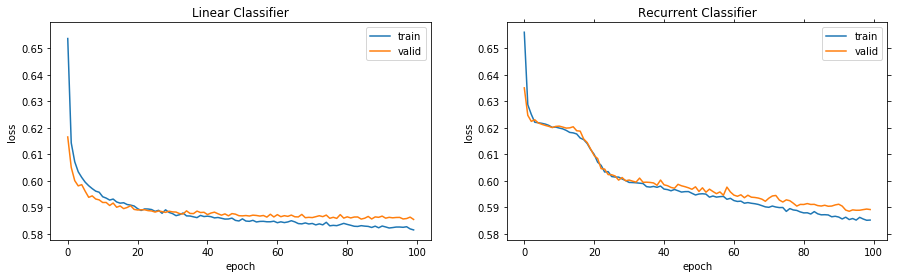

In [9]:
fig, (ax0, ax1) = plt.subplots(
    figsize=(15,4), nrows=1, ncols=2, sharey=True)

ax0.plot(linear_loss[0], label='train')
ax0.plot(linear_loss[1], label='valid')
ax0.set_title('Linear Classifier')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(recurrent_loss[0], label='train')
ax1.plot(recurrent_loss[1], label='valid')
ax1.set_title('Recurrent Classifier')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.tick_params(reset=True)

plt.show()

### Testing the trained models

In [10]:
print('Linear Classifier')
loss = validate(linear_classifier, test_dataloader, verbose=True)

print('\nRecurrent Classifier')
loss = validate(recurrent_classifier, test_dataloader, verbose=True)

Linear Classifier
	Validation ... loss:  0.5760
		TP: 3019	FP: 1652	OP: 4671
		FN: 1268	TN: 3595	ON: 4863
		CP: 4287	CN: 5247
	Accuracy: 69.37%	Precision:  0.65	Recall:  0.70

Recurrent Classifier
	Validation ... loss:  0.5780
		TP: 2582	FP: 1303	OP: 3885
		FN: 1705	TN: 3944	ON: 5649
		CP: 4287	CN: 5247
	Accuracy: 68.45%	Precision:  0.66	Recall:  0.60
